## 14.2 自己速度積分モデル

論文は2つ。主張は同じで、自己運動の速度を積分して自己位置を推定させるタスクをRNNに学習させると、中間層にグリッド細胞のような発火パターンが生まれたというもの。  

> C. Cueva, X. Wei. "Emergence of grid-like representations by training recurrent neural networks to perform spatial localization". *ICLR.* (2018). ([arxiv](https://arxiv.org/abs/1803.07770))

グリッド状の場所受容野がRNN(recurrent neural network)で形成されることを示す最初の論文。モデルは次図のような感じ。このモデルにおいて、次のような場所受容野が形成された。グリッド細胞の発達も一致することも示された。

> A. Banino, et al. "Vector-based navigation using grid-like representations in artificial agents". *Nat.* **557**(7705), 429–433 (2018). ([pdf](https://deepmind.com/documents/201/Vector-based%20Navigation%20using%20Grid-like%20Representations%20in%20Artificial%20Agents.pdf))

上の論文よりも出たのは少し遅いが、ほぼ同時期。強化学習のタスクで良い成績を出したことが注目されていたが、神経科学的にこの論文の注目すべき点はそこではない。  

タスクは(Cueva et al. 2018)とほぼ同じ。ただし、出力が自己位置のスカラー値ではなく、どの場所細胞の受容野に近いかの確率と、頭はどの方向を向いているかの確率となっている。どちらも一様分布から生成している。  

このモデルは3層からなり、再帰層(LSTM)、線形層、出力層から構成される。学習後の線形層には場所受容野が獲得されていた。  

さらにこのモデルが学習したグリッド細胞の特性は一致していた。

グリッド細胞の発火の方向が壁面から少しずれていることは謎であったが、この実験から、そうであることが最適であるということが分かった。つまり、壁面からずれていることで、格子パターンが空間全体を覆うことができ、一様な場所受容野の形成に役立っているといえる。  

もう1つ、この論文を読んで面白いと思ったのは、ニューラルネットワークを用いて脳の仕組みを明らかにすることについてのDeepMindの考えを知ることができたことである。"Supplementary Discussion:Relationship to previous models of grid cells"(pp.71)より一部引用。

> "It is worth noting that our experiments were not designed to provide insights into the development of grid cells in the brain — due to the limitations of the training algorithm used (i.e. backpropagation) in terms of biological plausibiliy. More generally, however, our findings accord with the perspective that the internal representations of individual brain regions such as the entorhinal cortex arise as a consequence of optimizing for specific ethologically important objective functions (e.g. path integration) — providing a parallel to the optimization process in neural networks."
>

日本語でまとめると、「ニューラルネットワークは誤差逆伝搬法などの学習方法の制約により、生物的な発達まで完全にシミュレーションはできない。しかし、脳の神経表現が生物学的に重要な目的関数（経路積分など）の最適化として生じるということは、ニューラルネットワークを通した実験で知ることができる。」ということ。ニューラルネットワークで脳の仕組みを知ることについては否定的な声もあるが、様々な論文を読んだ感想、および実際に研究している感想は、「ニューラルネットワークを用いれば、神経表現の"How(どのように獲得されたか)"は十分に分からなくても"Why(なぜそのような発火パターンなのか)"は知ることができる」というものである。当然、写像として定義できないことに関してはニューラルネットワークで考えることは難しい。しかし、写像で定義できるものに関しては、ニューラルネットワークは脳の仕組みを知るための強力なツールであると思う。  


## 14.2.1 学習データの生成

([Raudies & Hasselmo, PLoS Comput Biol. 2012](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553)) に従って作成。

### ラットの行動軌跡

In [2]:
using PyPlot
using Random
using Distributions

In [1]:
ROOM_LEN = 2.2 # Width and height of environment (meters)
PERIMETER_DIST = 0.03 # Perimeter region distance to walls (meters)
SIGMA_V = 0.13 # Forward velocity Rayleigh distribution scale (m/sec)
MU_PHI = 0.0  # Rotation velocity Gaussian distribution mean (rad/sec)
SIGMA_PHI = (330 / 360) * 2pi # Rotation velocity Gaussian distribution standard deviation (rad/sec)
RHO_RH = 0.25 # Velocity reduction factor when located in the perimeter

DELTA_T = 0.02 # Simulation-step time increment (seconds)

NUM_PLACE_CELL = 256 # Number of place cells
SIGMA_C = 0.01 # Place cell standard deviation parameter (meters)

0.01

In [3]:
wrap(x) = mod(x, 2pi) # limit 0~2pi angle

wrap (generic function with 1 method)

Juliaの余りの関数は `rem(x, y)` と `mod(x, y)`がある。Juliaの`x % y`は`rem`と同じだが、Pythonの場合は`mod`と同じなので、注意。

In [5]:
println("% : ", -1 % 2, ", rem : ", rem(-1, 2), ", mod : ", mod(-1, 2))

% : -1, rem : -1, mod : 1


In [6]:
# for square room of size ROOM_LEN x ROOM_LEN
# d:dist, a:angle
function minDistAngle(pos, theta)
    if pos[1] < PERIMETER_DIST
        dist_fm_wall = pos[1]
        angle_fm_wall = theta + pi
    elseif pos[2] < PERIMETER_DIST
        dist_fm_wall = pos[2]
        angle_fm_wall = theta + 1.5pi
    elseif pos[1] > ROOM_LEN - PERIMETER_DIST
        dist_fm_wall = ROOM_LEN - pos[1]
        angle_fm_wall = theta
    elseif pos[2] > ROOM_LEN - PERIMETER_DIST
        dist_fm_wall = ROOM_LEN - pos[2]
        angle_fm_wall = theta + 0.5pi
    else
        dist_fm_wall = 3.0
        angle_fm_wall = 0.0
    end

    angle_fm_wall = wrap(angle_fm_wall)

    return dist_fm_wall, angle_fm_wall
end

minDistAngle (generic function with 1 method)

In [7]:
function trajectory(num_steps)
    # store arrays
    positions = zeros(num_steps, 2)
    thetas = zeros(num_steps) # head direction
    speeds = zeros(num_steps) # Forward speed
    omegas = zeros(num_steps) # rotation velocity

    speed = 0.
    omega = 0.  # angular velocity
    pos = clamp.(rand(2) * ROOM_LEN, -0.1, ROOM_LEN-0.1)
    theta = rand() * 2pi  # angular pos

    # Iteration of trajectory
    for i in 1:num_steps
        dist_fm_wall, angle_fm_wall = minDistAngle(pos, theta)

        if (dist_fm_wall < PERIMETER_DIST) && (0 < angle_fm_wall < pi)
            # turn
            theta = sign(angle_fm_wall) * (pi - abs(angle_fm_wall)) + MU_PHI + randn()*SIGMA_PHI
            theta = wrap(theta)
            # slow down
            speed -= speed * RHO_RH
        else
            speed = rand(Rayleigh(SIGMA_V))
            omega = MU_PHI + randn()*SIGMA_PHI
        end
        
        velocity = speed * [sin(theta), cos(theta)]

        # update pos, angle
        pos += velocity * DELTA_T
        theta += omega * DELTA_T
        theta = wrap(theta)

        # store in array
        positions[i, :] = pos
        thetas[i] = theta
        speeds[i] = speed
        omegas[i] = omega
    end
        
    # inputs
    rot_vel = [sin.(omegas), cos.(omegas)]'
    forward_speed = speeds
    
    return positions, thetas, rot_vel, forward_speed
end

trajectory (generic function with 1 method)

In [10]:
positions, thetas, rot_vel, forward_speed  =  trajectory(20000)

size(positions)
#mu_c = generate_place_cells(True)

(20000, 2)

黒点から始まり、赤点に終わる。

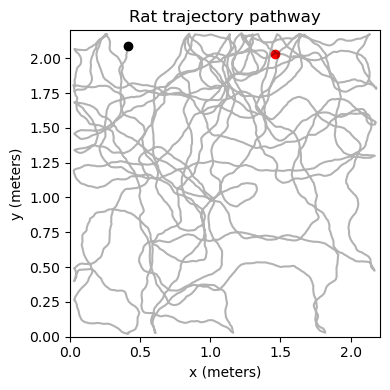

In [11]:
figure(figsize=(4, 4))
title("Rat trajectory pathway")
xlabel("x (meters)"); ylabel("y (meters)")
xlim((0, ROOM_LEN+0.01)); ylim((0, ROOM_LEN))
plot(positions[1, 1], positions[1, 2], "ko")
plot(positions[end, 1], positions[end, 2], "ro")
plot(positions[:, 1], positions[:, 2], color="k", alpha=0.3)
tight_layout()

### 場所細胞

In [12]:
function generate_place_cells()
    mu_c = rand(NUM_PLACE_CELL, 2)
    mu_c = mu_c * ROOM_LEN        
    return mu_c
end

generate_place_cells (generic function with 1 method)

In [29]:
function Gaussian2d(x0, y0, w=0.02)
    x = 0:w:ROOM_LEN-w
    y = 0:w:ROOM_LEN-w
    Y = [i for i in y, j in 1:length(x)]
    X = [j for i in 1:length(y), j in x]
    
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0*(SIGMA_C^2)))
end

Gaussian2d (generic function with 2 methods)

In [19]:
mu_c = generate_place_cells()

256×2 Array{Float64,2}:
 0.591535   1.61374
 1.68529    1.97057
 1.63557    0.765771
 1.39897    1.4916
 1.45847    1.79958
 1.87134    1.01796
 1.09351    0.73981
 2.05356    1.58835
 0.0186742  2.07894
 1.42991    0.579195
 1.23001    1.73018
 0.043254   1.1011
 1.04008    2.00336
 ⋮          
 1.69068    1.31775
 1.07795    0.345317
 0.496634   2.04245
 0.28006    2.04865
 0.270364   1.44516
 2.03274    0.699176
 2.18151    1.18808
 0.292246   0.181792
 0.0398304  1.00194
 1.7761     1.64277
 1.74561    1.13742
 1.61434    1.62122

場所細胞の

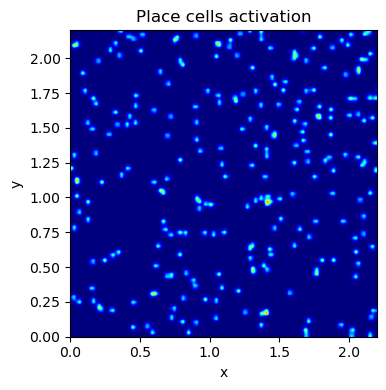

In [34]:
w = 0.02
mapsize = round(Int, ROOM_LEN/w)

activation = zeros(mapsize, mapsize)

for i in 1:NUM_PLACE_CELL
    activation += Gaussian2d(mu_c[i,1], mu_c[i,2], w)
end

figure(figsize=(4,4))
title("Place cells activation")
xlabel("x"); ylabel("y")
imshow(activation, cmap="jet", interpolation="gaussian", extent=[0, ROOM_LEN, ROOM_LEN, 0])
gca().invert_yaxis()

tight_layout()

In [ ]:
function softmax_gaussian(x, mu_c):
    d = -((mu_c[:, 0]-x[0])**2 + (mu_c[:, 1]-x[1])**2) / (2*SIGMA_C**2)
    #print(d.shape)
    max_d = np.max(d)
    exp_d = np.exp(d-max_d)
    return exp_d / np.sum(exp_d).astype(np.float32)
end

In [ ]:
function ground_truth_place_cell(mu_c, positions, traj_len):
    c = np.zeros((traj_len, NUM_PLACE_CELL))
    for i in range(traj_len):        
        c[i] = softmax_gaussian(positions[i], mu_c)
        
    return c.astype(np.float32)
end

In [ ]:
function generate_data(mu_c, traj_len=100):    
    #print("Trajectory Simulation")
    positions, thetas, rot_vel, forward_speed  =  trajectory(traj_len)
    
    inputs = np.concatenate((forward_speed, rot_vel), 1).astype(np.float32)
    
    #print("Generating Ground Truth")
    c = ground_truth_place_cell(mu_c, positions)
    
    return inputs, c, positions
end

## 結果の表示

In [1]:
using StatsBase

In [16]:
x = ones(5)*0.5
y = [1,2,3,4,5]/6

5-element Array{Float64,1}:
 0.16666666666666666
 0.3333333333333333
 0.5
 0.6666666666666666
 0.8333333333333334

真の位置をx, yとし、ユニットの活動をzとすると、重みづけができる。

In [19]:
z = [1, 2, 3, 4, 5]

5-element Array{Int64,1}:
 1
 2
 3
 4
 5

In [20]:
hist = fit(Histogram, (x, y), weights(z), (0:0.1:1.0, 0:0.1:1.0)).weights # activation

10×10 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  1  0  2  0  3  4  0  5  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0


- https://github.com/deepmind/grid-cells
- https://github.com/R-Stefano/Grid-Cells